In [1]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install ngboost

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=3e7f3746c1e11cdfb4771f9cb0b2ae079ec3b3d7e020480058205ae47d51b658
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [3]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
#import dataset
fatigue_df = pd.read_csv('../Data/Titanium_Alloy_UC.csv', encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.00,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7


In [5]:
fatigue_df.info()

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

In [6]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.050,0.0025,0.000,0.004,0.00,0.340,4.00,0.70,0.500,3.70
1,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
2,700.06,1025,2.0,400,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
3,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
4,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,293.94,0,0.0,750,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00
216,282.17,0,0.0,600,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00
217,253.59,0,0.0,25,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00
218,180.72,0,0.0,400,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00


In [7]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
[iter 0] loss=1.9480 val_loss=1.9288 scale=1.0000 norm=0.5178
[iter 100] loss=1.5489 val_loss=1.5859 scale=2.0000 norm=0.8583
[iter 200] loss=1.0932 val_loss=1.2736 scale=2.0000 norm=0.8742
== Early stopping achieved.
== Best iteration / VAL272 (val_loss=1.1827)
Pearson CC: 0.8636209572780641
R2 score: 0.7362247227391249
RMSE: 1.0181019041367312
MAE: 0.6838559061851449
Coverage: 93.18181818181817
Median Interval Width: 4.123584125061141
Composite Metric: 0.7594905066827408


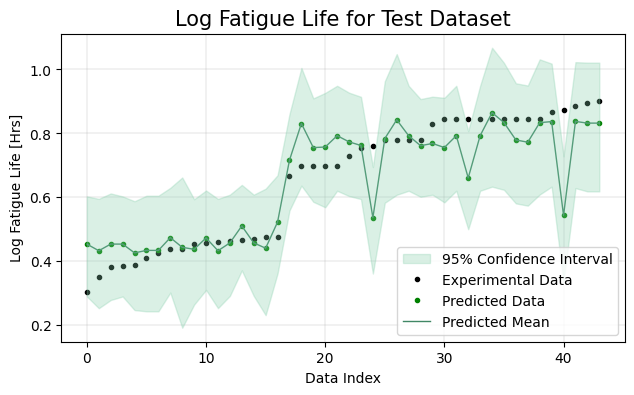

Run # 1 Fold # 2
[iter 0] loss=1.9947 val_loss=1.9904 scale=1.0000 norm=0.5235
[iter 100] loss=1.6325 val_loss=1.6309 scale=2.0000 norm=0.8693
[iter 200] loss=1.1879 val_loss=1.1705 scale=2.0000 norm=0.8741
[iter 300] loss=0.8225 val_loss=0.8047 scale=2.0000 norm=0.8309
[iter 400] loss=0.5399 val_loss=0.5516 scale=2.0000 norm=0.7541
[iter 500] loss=0.3251 val_loss=0.4331 scale=2.0000 norm=0.7173
[iter 600] loss=0.1931 val_loss=0.4077 scale=2.0000 norm=0.7076
== Early stopping achieved.
== Best iteration / VAL604 (val_loss=0.4075)
Pearson CC: 0.9488813692528107
R2 score: 0.898608318114212
RMSE: 0.5818690041159814
MAE: 0.39573692334050353
Coverage: 86.36363636363635
Median Interval Width: 1.551749551927173
Composite Metric: 0.8088357452185428


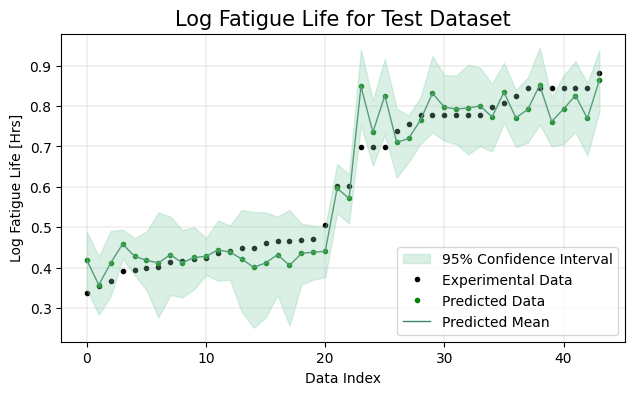

Run # 1 Fold # 3
[iter 0] loss=1.9945 val_loss=1.9987 scale=1.0000 norm=0.5187
[iter 100] loss=1.6499 val_loss=1.6547 scale=2.0000 norm=0.8676
[iter 200] loss=1.2706 val_loss=1.2719 scale=2.0000 norm=0.8609
[iter 300] loss=0.9050 val_loss=0.9173 scale=2.0000 norm=0.8270
[iter 400] loss=0.6284 val_loss=0.6990 scale=2.0000 norm=0.7677
[iter 500] loss=0.4286 val_loss=0.6211 scale=2.0000 norm=0.7086
== Early stopping achieved.
== Best iteration / VAL541 (val_loss=0.6116)
Pearson CC: 0.9452693406114839
R2 score: 0.892104664460569
RMSE: 0.6033665087147652
MAE: 0.43170015862643685
Coverage: 86.36363636363636
Median Interval Width: 1.6771753950161272
Composite Metric: 0.7967874132128157


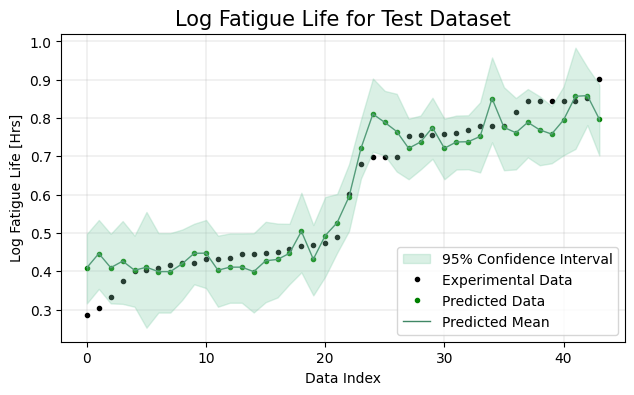

Run # 1 Fold # 4
[iter 0] loss=1.9958 val_loss=1.9953 scale=1.0000 norm=0.5130
[iter 100] loss=1.6476 val_loss=1.6313 scale=1.0000 norm=0.4305
[iter 200] loss=1.2327 val_loss=1.1898 scale=2.0000 norm=0.8562
[iter 300] loss=0.8812 val_loss=0.8215 scale=2.0000 norm=0.8144
[iter 400] loss=0.6089 val_loss=0.5169 scale=2.0000 norm=0.7743
[iter 500] loss=0.4065 val_loss=0.3264 scale=1.0000 norm=0.3659
[iter 600] loss=0.2771 val_loss=0.2490 scale=2.0000 norm=0.7115
[iter 700] loss=0.1846 val_loss=0.2062 scale=1.0000 norm=0.3558
== Early stopping achieved.
== Best iteration / VAL749 (val_loss=0.1939)
Pearson CC: 0.9388094599679425
R2 score: 0.8675959514183778
RMSE: 0.6906473637318928
MAE: 0.45141063275491894
Coverage: 77.27272727272727
Median Interval Width: 0.9721407657784824
Composite Metric: 0.8367098578917149


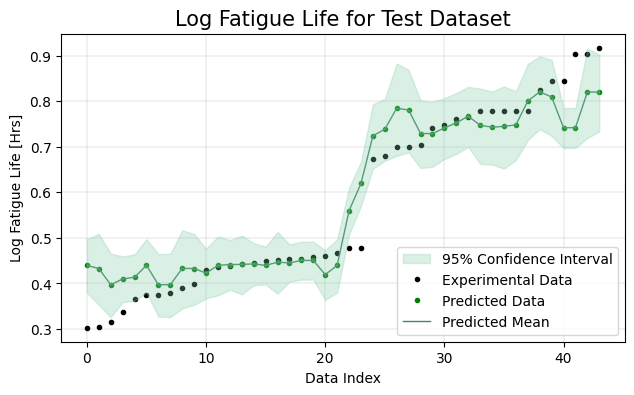

Run # 1 Fold # 5
[iter 0] loss=2.0105 val_loss=2.0087 scale=1.0000 norm=0.5168
[iter 100] loss=1.6378 val_loss=1.6185 scale=2.0000 norm=0.8641
[iter 200] loss=1.1878 val_loss=1.1475 scale=2.0000 norm=0.8646
[iter 300] loss=0.8298 val_loss=0.7811 scale=2.0000 norm=0.8221
[iter 400] loss=0.5559 val_loss=0.5684 scale=2.0000 norm=0.7648
[iter 500] loss=0.3446 val_loss=0.4700 scale=2.0000 norm=0.7309
== Early stopping achieved.
== Best iteration / VAL522 (val_loss=0.4661)
Pearson CC: 0.9412467115530162
R2 score: 0.8848123182320091
RMSE: 0.6313510931214226
MAE: 0.4505155082854726
Coverage: 81.8181818181818
Median Interval Width: 1.258777687379246
Composite Metric: 0.812241727003183


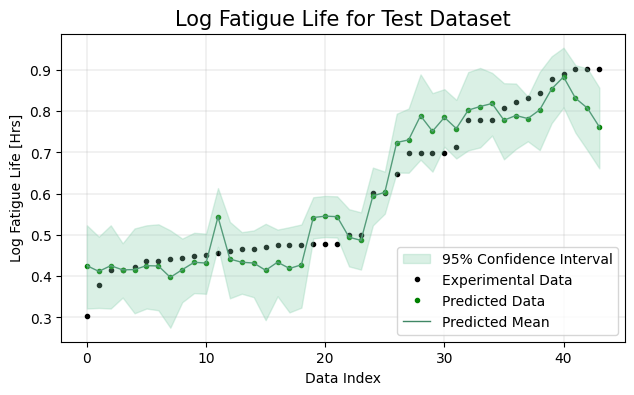

In [8]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]
            X_train, X_val, y_train, Y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42)


            model = NGBRegressor(Dist=LogNormal, n_estimators=1000, learning_rate=0.005)
            model.fit(X_train, y_train, X_val=X_val, Y_val=Y_val, early_stopping_rounds=4)

            y_pred_test = model.predict(X_test)
            y_test_ngb = model.pred_dist(X_test)

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            df_test_low = y_test_ngb.interval(0.95)[0]
            df_test_median = y_pred_test
            df_test_high = y_test_ngb.interval(0.95)[1]

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)

            print(f'Coverage: {test_coverage[j, i]}')
            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test
            y_std = np.std(np.array(y_pred_test), axis=0)

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.log10(df_test_low), np.log10(df_test_high), alpha=0.3, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, np.log10(y_test), 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.log10(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, np.log10(y_pred), '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Fatigue Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Fatigue Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

In [9]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.863621,0.736225,1.018102,0.683856,93.181818
1,0.948881,0.898608,0.581869,0.395737,86.363636
2,0.945269,0.892105,0.603367,0.431700,86.363636
3,0.938809,0.867596,0.690647,0.451411,77.272727
4,0.941247,0.884812,0.631351,0.450516,81.818182


In [10]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.927566,0.032157,0.855869,0.060712,0.705067,0.160719,0.482644,0.102608,85.0,5.300865


In [11]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,93.181818,4.123584,0.759491
1,86.363636,1.551750,0.808836
2,86.363636,1.677175,0.796787
3,77.272727,0.972141,0.836710
4,81.818182,1.258778,0.812242


In [12]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)

median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,85.0,5.300865,1.916686,1.130129,0.802813,0.025248
